In [19]:
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.model.models import DBModelSmall, DBModelBig, DWSModelForClassification, SetTransformer, MLP
from src.data.datasets import ModelParamsDataset, ModelDataset
from src.data.helpers import get_moons_dataset

from tqdm import tqdm

## Accuracy comparison on the big dataset

In [18]:
from src.data.helpers import evaluate_dwsnets, get_accuracy_st, get_accuracy_mlp

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

splits = [[0.001, 0.001, 0.998], [0.01, 0.01, 0.98], [0.02, 0.02, 0.96], [0.05, 0.05, 0.9], [0.1, 0.1, 0.8], [0.2, 0.2, 0.6], [0.5, 0.3, 0.2], [0.7, 0.2, 0.1], [0.8, 0.1, 0.1], [0.9, 0.05, 0.05]]

# DWSNets config
normalize = True
batch_size = 512
num_workers = 4

# Set Tranformers
pos_emb = torch.tensor([0] * 30 + [1] * 110 + [2] * 110 + [3] * 11)
type_emb = torch.tensor([0] * 20 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 100 + [1] * 10 + [0] * 10 + [1] * 1)
emb = torch.stack([pos_emb, type_emb], dim=1)

dataset = ModelParamsDataset("../data/eight_angles_big.csv", get_as_classes=True)

accuracies_mlp = dict()
accuracies_st = dict()
accuracies_dwsnets = dict()

In [22]:
for split in tqdm(splits):
    # DWSNets
    train_dataset_size = split[0] * 10000
    val_dataset_size = split[1] * 10000
    test_dataset_size = split[2] * 10000
    splits_path = f"../data/dataset_splits_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"
    statistics_path = f"../data/statistics_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"

    test_set = ModelDataset(path=splits_path, split="test", normalize=normalize, statistics_path=statistics_path)
    test_loader = torch.utils.data.DataLoader( dataset=test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    point = test_set.__getitem__(0)
    weight_shapes = tuple(w.shape[:2] for w in point.weights)
    bias_shapes = tuple(b.shape[:1] for b in point.biases)

    model = DWSModelForClassification( weight_shapes=weight_shapes, bias_shapes=bias_shapes, input_features=1, hidden_dim=32, n_hidden=4, n_classes=8, bn=True).to(device).eval()
    model.load_state_dict(torch.load(f"../models/classifiers/dwsnets/dwsnets_{split[0]}.pth"))

    eval_data = evaluate_dwsnets(model, test_loader, device)
    accuracy = eval_data["avg_acc"]
    accuracies_dwsnets[split[0]] = accuracy.item()

    # Set Transformers
    torch.manual_seed(42)
    _, _, dataset_test = torch.utils.data.random_split(dataset, split)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    model = SetTransformer(3, 8, 1).to(device).eval()
    model.load_state_dict(torch.load(f"../models/classifiers/set_transformers/set-transformer_{split[0]}.pth"))

    accuracy = get_accuracy_st(model, dataloader_test, emb)
    accuracies_st[split[0]] = accuracy

    # MLP
    model = MLP(261, [400, 200], 8, 0.2, True, "softmax").to(device)
    model.load_state_dict(torch.load(f"../models/classifiers/mlp/big/mlp_{split[0]}.pth"))
    
    accuracy = get_accuracy_mlp(model, dataloader_test, device)
    accuracies_mlp[split[0]] = accuracy


100%|██████████| 10/10 [17:57<00:00, 107.76s/it]


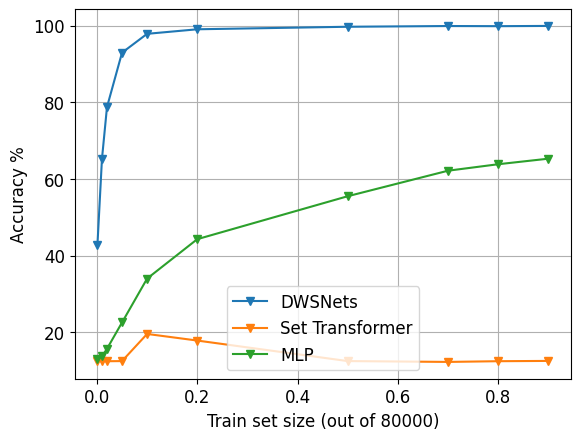

In [26]:
plt.rcParams.update({"font.size": 12})
x = list(accuracies_dwsnets.keys())
y_dwsnets = list(accuracies_dwsnets.values())
y_dwsnets = [acc * 100 for acc in y_dwsnets]
y_st = list(accuracies_st.values())
y_mlp = list(accuracies_mlp.values())

plt.plot(x, y_dwsnets, label="DWSNets", marker="v")
plt.plot(x, y_st, label="Set Transformer", marker="v")
plt.plot(x, y_mlp, label="MLP", marker="v")

plt.xlabel("Train set size (out of 80000)")
plt.ylabel("Accuracy %")
plt.legend()
plt.grid()
plt.savefig("../reports/classifiers-accuracy.pdf")
plt.show()

In [22]:
accuracies_dwsnets = dict()
for split in tqdm(splits):
    # DWSNets
    train_dataset_size = 0.7 * 10000
    val_dataset_size = 0.2 * 10000
    test_dataset_size = 0.1 * 10000
    splits_path = f"../data/dataset_splits_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"
    statistics_path = f"../data/statistics_{train_dataset_size}_{val_dataset_size}_{test_dataset_size}.json"

    test_set = ModelDataset(path=splits_path, split="test", normalize=normalize, statistics_path=statistics_path)
    test_loader = torch.utils.data.DataLoader( dataset=test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    point = test_set.__getitem__(0)
    weight_shapes = tuple(w.shape[:2] for w in point.weights)
    bias_shapes = tuple(b.shape[:1] for b in point.biases)

    model = DWSModelForClassification( weight_shapes=weight_shapes, bias_shapes=bias_shapes, input_features=1, hidden_dim=32, n_hidden=4, n_classes=8, bn=True).to(device).eval()
    model.load_state_dict(torch.load(f"../models/classifiers/dwsnets/dwsnets_{split[0]}.pth"))

    eval_data = evaluate_dwsnets(model, test_loader, device)
    accuracy = eval_data["avg_acc"]
    accuracies_dwsnets[split[0]] = accuracy.item()

100%|██████████| 10/10 [02:17<00:00, 13.77s/it]


In [23]:
print(accuracies_dwsnets)

{0.001: 0.44875001907348633, 0.01: 0.6522500514984131, 0.02: 0.7852500081062317, 0.05: 0.9260000586509705, 0.1: 0.9798750281333923, 0.2: 0.9895000457763672, 0.5: 0.9985000491142273, 0.7: 0.9987500309944153, 0.8: 1.0, 0.9: 1.0}


## Accuracy plot

In [2]:
plt.rcParams.update({"font.size": 24})

Text(0.5, 0, 'Accuracy %')

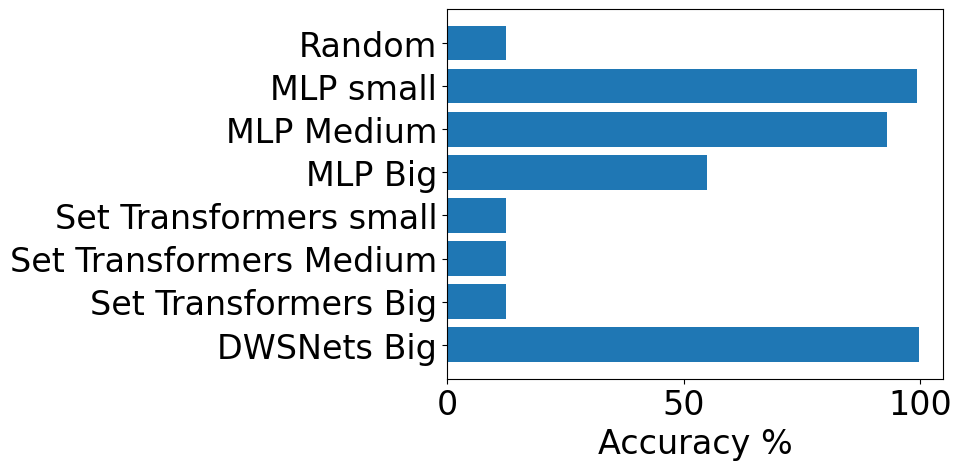

In [17]:
labels = ["Random", "MLP small", "MLP Medium", "MLP Big", "Set Transformers small", "Set Transformers Medium", "Set Transformers Big", "DWSNets Big"]
labels.reverse()
x = [12.5, 99.3, 93.0, 55, 12.5, 12.4, 12.45, 99.8]
x.reverse()
plt.barh(labels, x)
plt.xlabel("Accuracy %")